<a href="https://colab.research.google.com/github/Niloufar-soheili/copula-hydrology-analysis/blob/main/Site8162500_Copula.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ==============================================================================
# 0. SETUP AND IMPORTS
# ==============================================================================

# --- Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from google.colab import drive

# --- Mount Google Drive ---
# This allows the notebook to access files stored in your Google Drive.
# You will be prompted for authorization the first time you run this.
print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Drive mounted successfully.")

Mounting Google Drive...
Mounted at /content/drive
Drive mounted successfully.


In [3]:
# ==============================================================================
# 1. DATA LOADING AND PRE-PROCESSING
# ==============================================================================

# --- Load the Dataset ---
# We specify the data types for 'site_no' to avoid issues and use 'low_memory=False'
# as a good practice for potentially large, mixed-type files.
try:
    file_path = '/content/drive/MyDrive/IFMHA/ifmha_subset_stat.csv'
    ifmha_subset_stat = pd.read_csv(
        file_path,
        converters={'site_no': str},
        low_memory=False
    )
    print(f"Data loaded successfully. Shape of the DataFrame: {ifmha_subset_stat.shape}")
except FileNotFoundError:
    print(f"ERROR: File not found at '{file_path}'. Please check the path.")
    exit() # Stop if the file can't be found

# --- Perform Unit Conversions ---
# Convert discharge from cubic feet per second (cfs) to cubic meters per second (m³/s)
ifmha_subset_stat['discharge_m3s'] = ifmha_subset_stat['discharge_va'] * 0.028316832

# Convert stage from feet (ft) to meters (m)
ifmha_subset_stat['stage_m'] = ifmha_subset_stat['gage_height_va'] * 0.3048


Data loaded successfully. Shape of the DataFrame: (2064782, 49)



Found 6494 sites with valid data for plotting.
Generating plots for 40 sites...


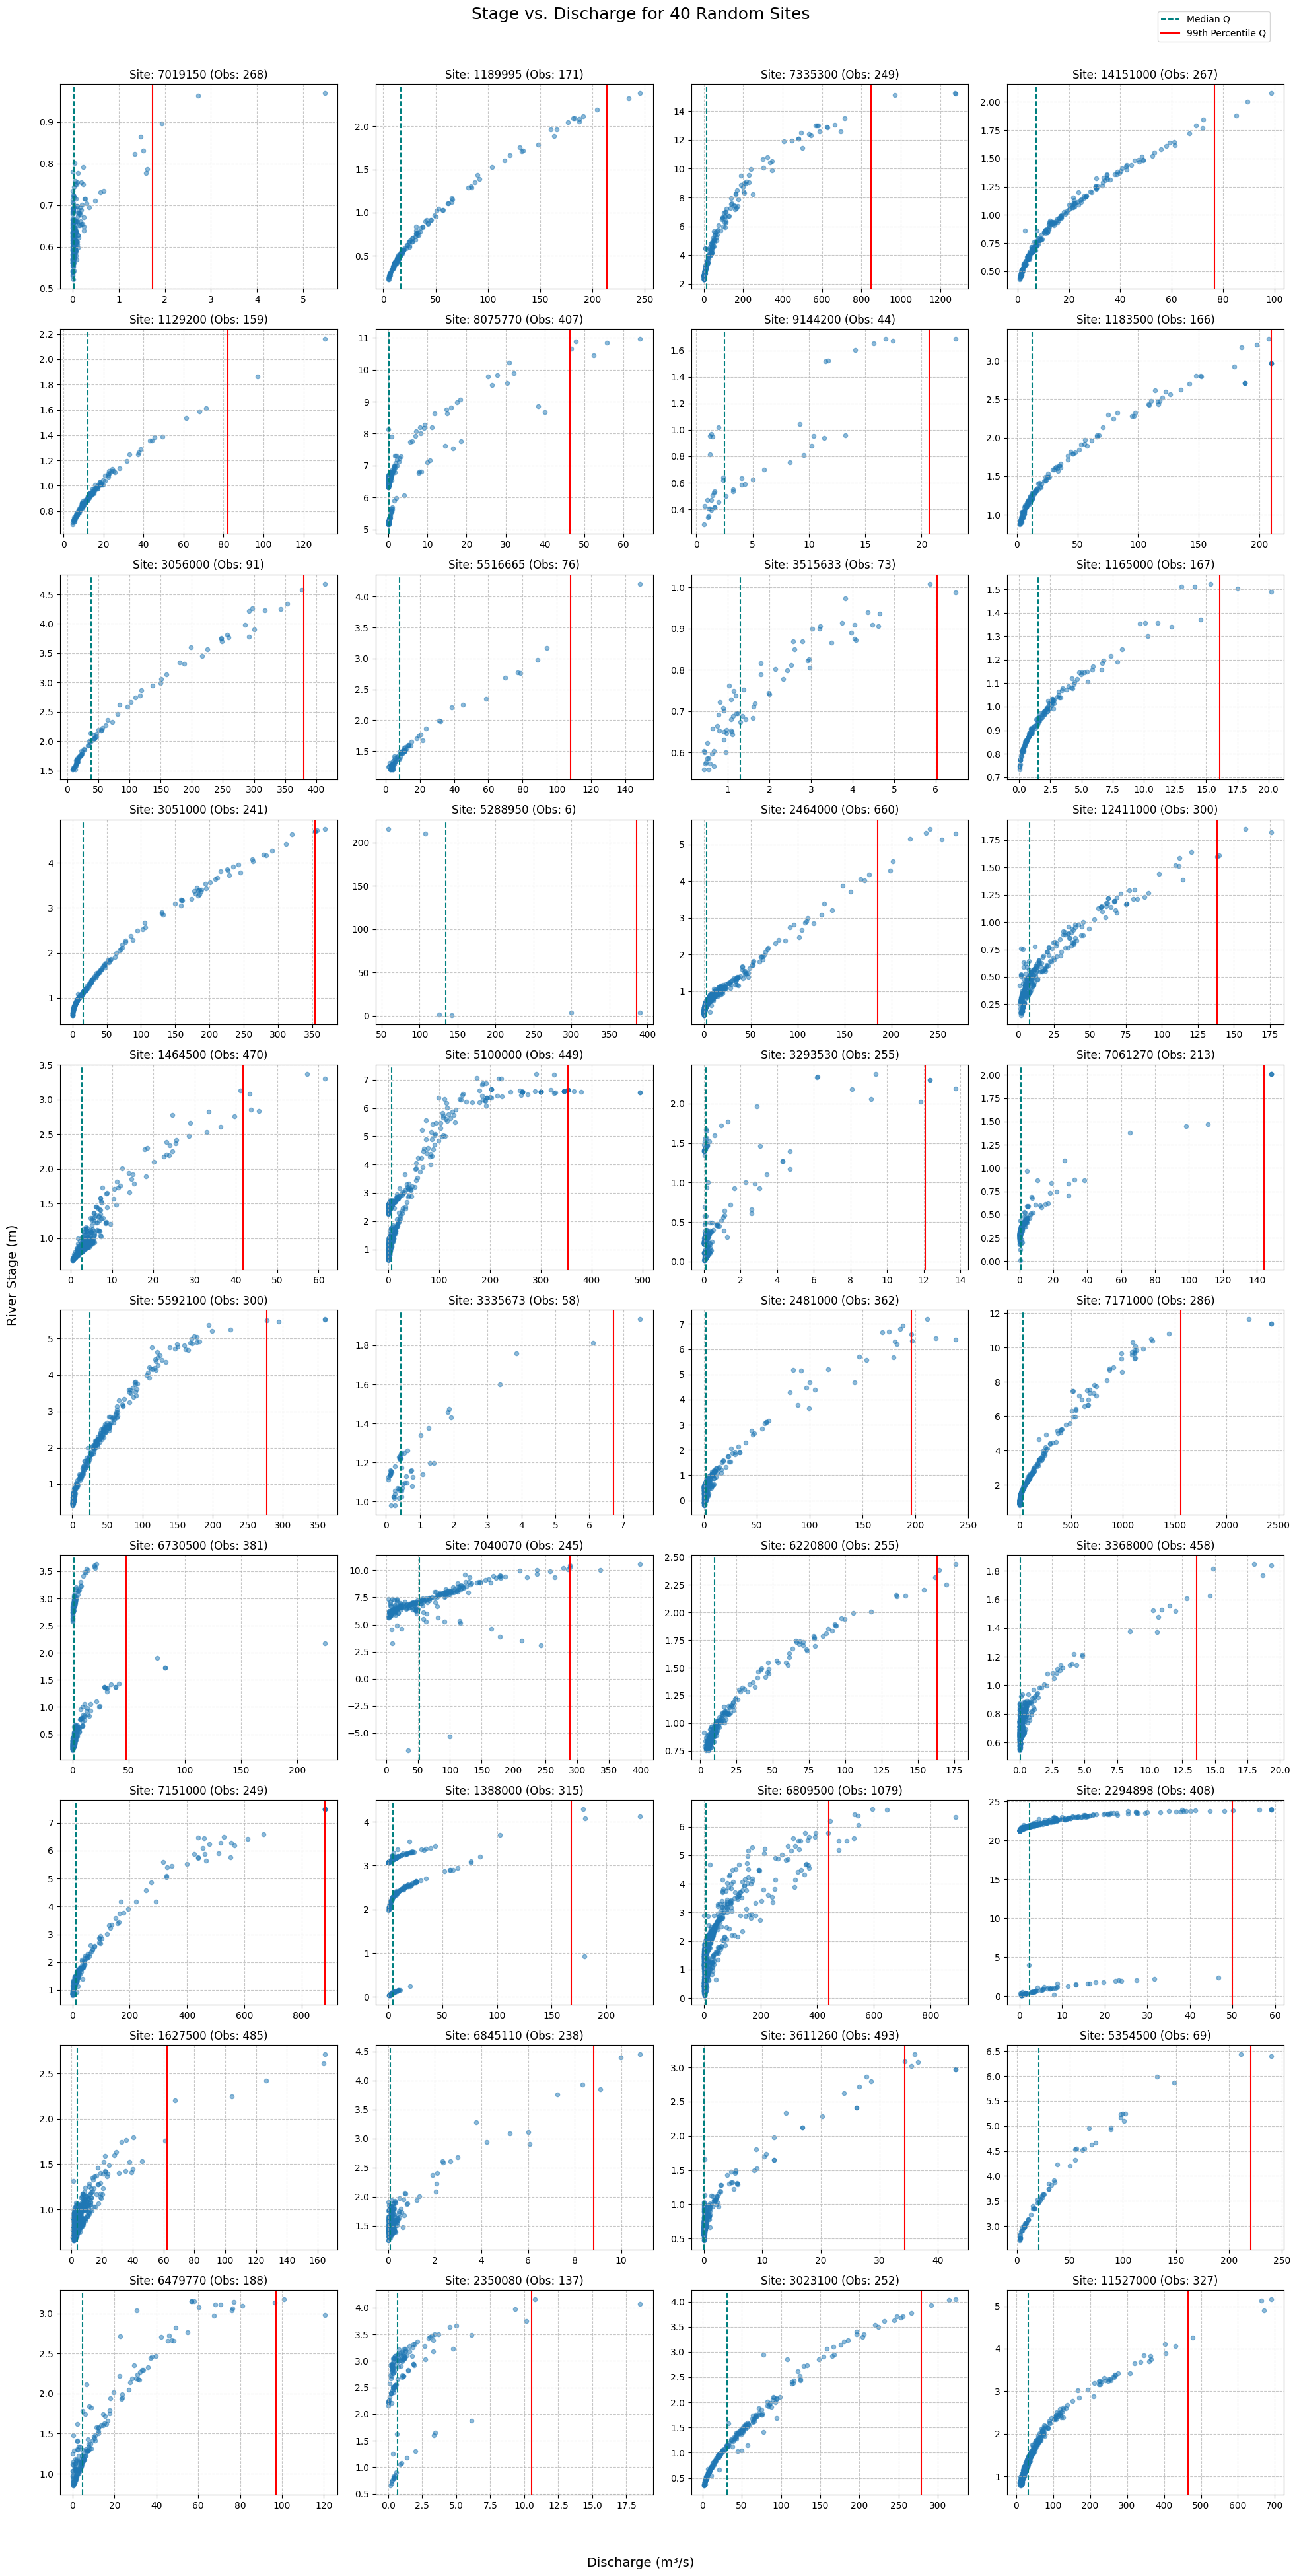

In [4]:
# ==============================================================================
# 2. EXPLORATORY VISUALIZATION OF RANDOM SITES
# ==============================================================================

# --- Group the data by site number ---
# First, drop any rows where gage height is missing, as it's essential for plotting.
grouped_ifmha = ifmha_subset_stat.dropna(subset=['gage_height_va']).groupby('site_no')
site_no_list = list(grouped_ifmha.groups.keys())
print(f"\nFound {len(site_no_list)} sites with valid data for plotting.")

# --- Configuration for the Plot ---
num_sites_to_plot = 40  # You can easily change this number
n_cols = 4              # Number of columns in the plot grid

# --- Select a random sample of sites ---
# Ensure we don’t try to plot more sites than are available
num_sites_to_plot = min(num_sites_to_plot, len(site_no_list))
# Use a random number generator with a seed for reproducible random selection
rng = np.random.default_rng(42)
random_indices = rng.choice(len(site_no_list), num_sites_to_plot, replace=False)
selected_sites = [site_no_list[i] for i in random_indices]

# --- Create the Subplot Grid ---
n_rows = math.ceil(num_sites_to_plot / n_cols)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 4 * n_rows))

# Flatten the axes array for easy iteration, even if it's a single plot
axes_flat = axes.flatten()

print(f"Generating plots for {num_sites_to_plot} sites...")

# --- Loop through the selected sites and create each plot ---
for idx, sn in enumerate(selected_sites):
    ax = axes_flat[idx]

    # Get the data for the current site
    df = grouped_ifmha.get_group(sn)

    # Use the pre-converted metric columns
    q = df["discharge_m3s"]
    s = df["stage_m"]

    # Filter extreme outliers within this specific site (1% to 99% percentile)
    # This is done on a per-site basis to respect local conditions.
    is_within_quantiles = (s > s.quantile(0.01)) & (s < s.quantile(0.99))
    q_filtered = q[is_within_quantiles]
    s_filtered = s[is_within_quantiles]

    # Create the scatter plot
    ax.scatter(q_filtered, s_filtered, alpha=0.5, s=20)
    ax.axvline(x=q_filtered.median(), color='teal', linestyle='--', label='Median Q')
    ax.axvline(x=q_filtered.quantile(0.99), color='red', linestyle='-', label='99th Percentile Q')

    ax.set_title(f"Site: {sn} (Obs: {len(q_filtered)})")
    ax.grid(True, linestyle='--', alpha=0.7)

# --- Final Formatting for the Figure ---
# Hide any subplots that were not used
for i in range(num_sites_to_plot, len(axes_flat)):
    axes_flat[i].axis('off')

# Add a single, shared legend for the entire figure to avoid clutter
handles, labels = axes_flat[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.98, 0.98))

# Add shared axis labels
fig.supxlabel('Discharge (m³/s)', fontsize=14)
fig.supylabel('River Stage (m)', fontsize=14)

# Adjust layout to prevent titles and labels from overlapping
plt.tight_layout(rect=[0.02, 0.02, 1, 0.96])
fig.suptitle(f"Stage vs. Discharge for {num_sites_to_plot} Random Sites", fontsize=18)
plt.show()

Successfully extracted 593 records for site 8162500.


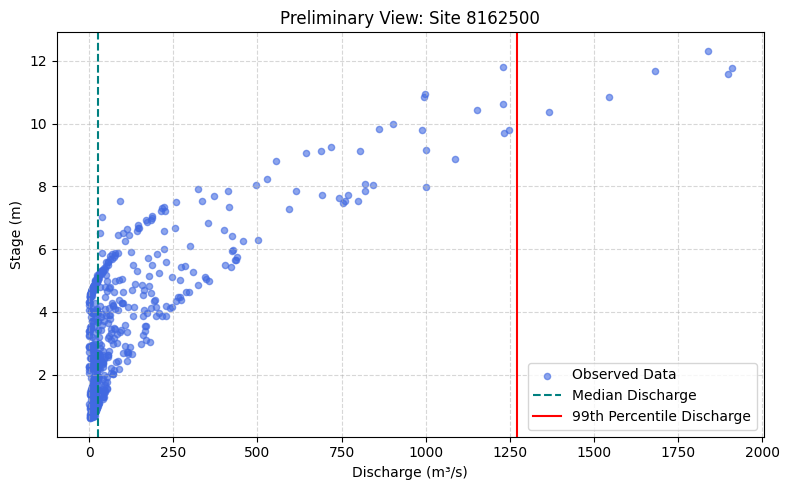

In [5]:
# ==============================================================================
# 3. SELECT AND VISUALIZE A SPECIFIC TARGET SITE
# ==============================================================================
# --- Configuration ---
# You can easily change this to any site number that exists in your dataset.
TARGET_SITE = '8162500'

# --- Extract Data for the Target Site ---
# We use the 'grouped_ifmha' object created in the previous cell.
# A try-except block handles cases where the site might not exist.
try:
    site_df = grouped_ifmha.get_group(TARGET_SITE).copy()
    print(f"Successfully extracted {len(site_df)} records for site {TARGET_SITE}.")
except KeyError:
    print(f"ERROR: Site {TARGET_SITE} not found in the cleaned, grouped data.")
    print("Please choose a different site number from the list in the previous cell.")
    exit()

# --- Initial Outlier Filtering for Visualization ---
# A simple quantile filter to clean up the plot and focus on the main data cloud.
q_vis = site_df['discharge_m3s']
s_vis = site_df['stage_m']

# Filter out the top and bottom 1% of stage values for a clearer plot
is_within_quantiles_vis = (s_vis > s_vis.quantile(0.01)) & (s_vis < s_vis.quantile(0.99))
q_vis_filtered = q_vis[is_within_quantiles_vis]
s_vis_filtered = s_vis[is_within_quantiles_vis]

# --- Create a Preliminary Plot for the Selected Site ---
plt.figure(figsize=(8, 5))
plt.scatter(q_vis_filtered, s_vis_filtered, color='royalblue', alpha=0.6, s=20, label='Observed Data')

# Add vertical lines for context
plt.axvline(x=q_vis_filtered.median(), color='teal', linestyle='--', label='Median Discharge')
plt.axvline(x=q_vis_filtered.quantile(0.99), color='red', linestyle='-', label='99th Percentile Discharge')

# Formatting
plt.xlabel("Discharge (m³/s)")
plt.ylabel("Stage (m)")
plt.title(f"Preliminary View: Site {TARGET_SITE}")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# The 'site_df' DataFrame, containing all data for the target site, is now ready for modeling.

After cleaning for rating curve fit, 573 rows remain.

Fitted Rating Curve Parameters: C=1.757, n=2.834, H0=0.610


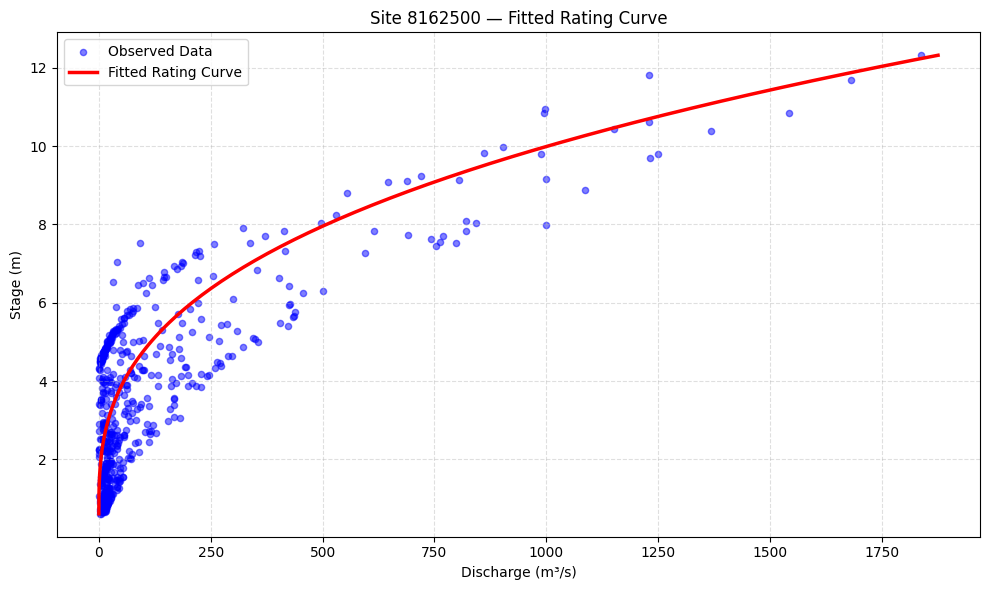

In [6]:
# ==============================================================================
# 4. FIT AND PLOT THE TRADITIONAL RATING CURVE
# ==============================================================================
from scipy.optimize import curve_fit

# --- 1. Prepare Data for Modeling ---
# Use the 'site_df' from the previous cell and drop any remaining NaNs.
obs_df = site_df[['discharge_m3s', 'stage_m']].dropna().copy()

# A robust quantile-based filter to remove extreme outliers before fitting the model.
q_lo = obs_df['discharge_m3s'].quantile(0.01)
q_hi = obs_df['discharge_m3s'].quantile(0.99)
h_lo = obs_df['stage_m'].quantile(0.01)
h_hi = obs_df['stage_m'].quantile(0.99)

obs_df_filtered = obs_df[
    (obs_df['discharge_m3s'] >= q_lo) & (obs_df['discharge_m3s'] <= q_hi) &
    (obs_df['stage_m'] >= h_lo) & (obs_df['stage_m'] <= h_hi)
].copy()

print(f"After cleaning for rating curve fit, {len(obs_df_filtered)} rows remain.")

# --- 2. Define and Fit the Rating Curve Model ---
# Define the power-law model function
def rating_curve_model(H, C, n, H0):
    """ Power-law model for a rating curve: Q = C * (H - H0)^n """
    return C * np.maximum(0.0, H - H0) ** n

# Extract observed data into NumPy arrays for the fitting function
Q_obs = obs_df_filtered['discharge_m3s'].values
H_obs = obs_df_filtered['stage_m'].values

# Fit the curve using scipy.optimize.curve_fit.
# A try-except block handles cases where the fit fails to converge.
try:
    # --- CORRECTED GUESSES AND BOUNDS ---
    # A more robust initial guess for H0 (zero-flow stage)
    H0_guess = H_obs.min() * 0.95

    # A more robust guess for C
    C_guess = Q_obs.mean() / max((H_obs.mean() - H0_guess)**2.0, 1e-8)

    # The initial guess vector for parameters [C, n, H0]
    p0 = [C_guess, 2.0, H0_guess]

    # A more physically meaningful and robust set of bounds.
    # The upper bound for H0 is now the minimum observed stage.
    # The upper bound for n is set to 5 for stability.
    bounds = ([0.0, 0.0, -np.inf], [np.inf, 5.0, H_obs.min()])

    # Perform the curve fitting
    (C_fit, n_fit, H0_fit), _ = curve_fit(
        rating_curve_model, H_obs, Q_obs,
        p0=p0, bounds=bounds, maxfev=20000
    )
    print(f"\nFitted Rating Curve Parameters: C={C_fit:.3f}, n={n_fit:.3f}, H0={H0_fit:.3f}")

    # --- 3. Generate the Fitted Curve for Plotting ---
    # Create a smooth series of stage values to plot the curve.
    H_grid_rc = np.linspace(H_obs.min(), H_obs.max(), 200)
    Q_fit_rc = rating_curve_model(H_grid_rc, C_fit, n_fit, H0_fit)

    # --- 4. Plot the Results ---
    plt.figure(figsize=(10, 6))
    plt.scatter(Q_obs, H_obs, color='blue', alpha=0.5, s=20, label='Observed Data')
    plt.plot(Q_fit_rc, H_grid_rc, 'r-', lw=2.5, label='Fitted Rating Curve')
    plt.xlabel("Discharge (m³/s)")
    plt.ylabel("Stage (m)")
    plt.title(f"Site {TARGET_SITE} — Fitted Rating Curve")
    plt.legend()
    plt.grid(True, alpha=0.4, linestyle='--')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"\nERROR: Rating curve fitting failed. The plot cannot be generated.")
    print(f"This can happen if the data is not well-suited for a power-law fit.")
    print(f"Error details: {e}")

In [7]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 92.2 MB/s eta 0:00:00


In [8]:
!pip -q install copulas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 3.2 MB/s eta 0:00:00


Using the cleaned 573 data points from the rating curve analysis.

--- Fitting Marginal Distributions ---


/usr/local/lib/python3.12/dist-packages/scipy/stats/_continuous_distns.py:796: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_continuous_distns.py:801: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


Best distribution for Discharge (x): BetaUnivariate


/usr/local/lib/python3.12/dist-packages/scipy/stats/_continuous_distns.py:796: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


Best distribution for Stage (y): TruncatedGaussian

--- Fitting and Scoring Copula Families ---

Copula comparison (sorted by BIC):
  family         ll         AIC         BIC
  gumbel 171.302786 -340.605573 -336.254687
gaussian 137.956563 -273.913125 -269.562239
   frank 122.993939 -243.987878 -239.636992
 clayton -46.678534   95.357069   99.707954

Best copula (by BIC): Gumbel

--- Generating Synthetic Data from each Copula ---


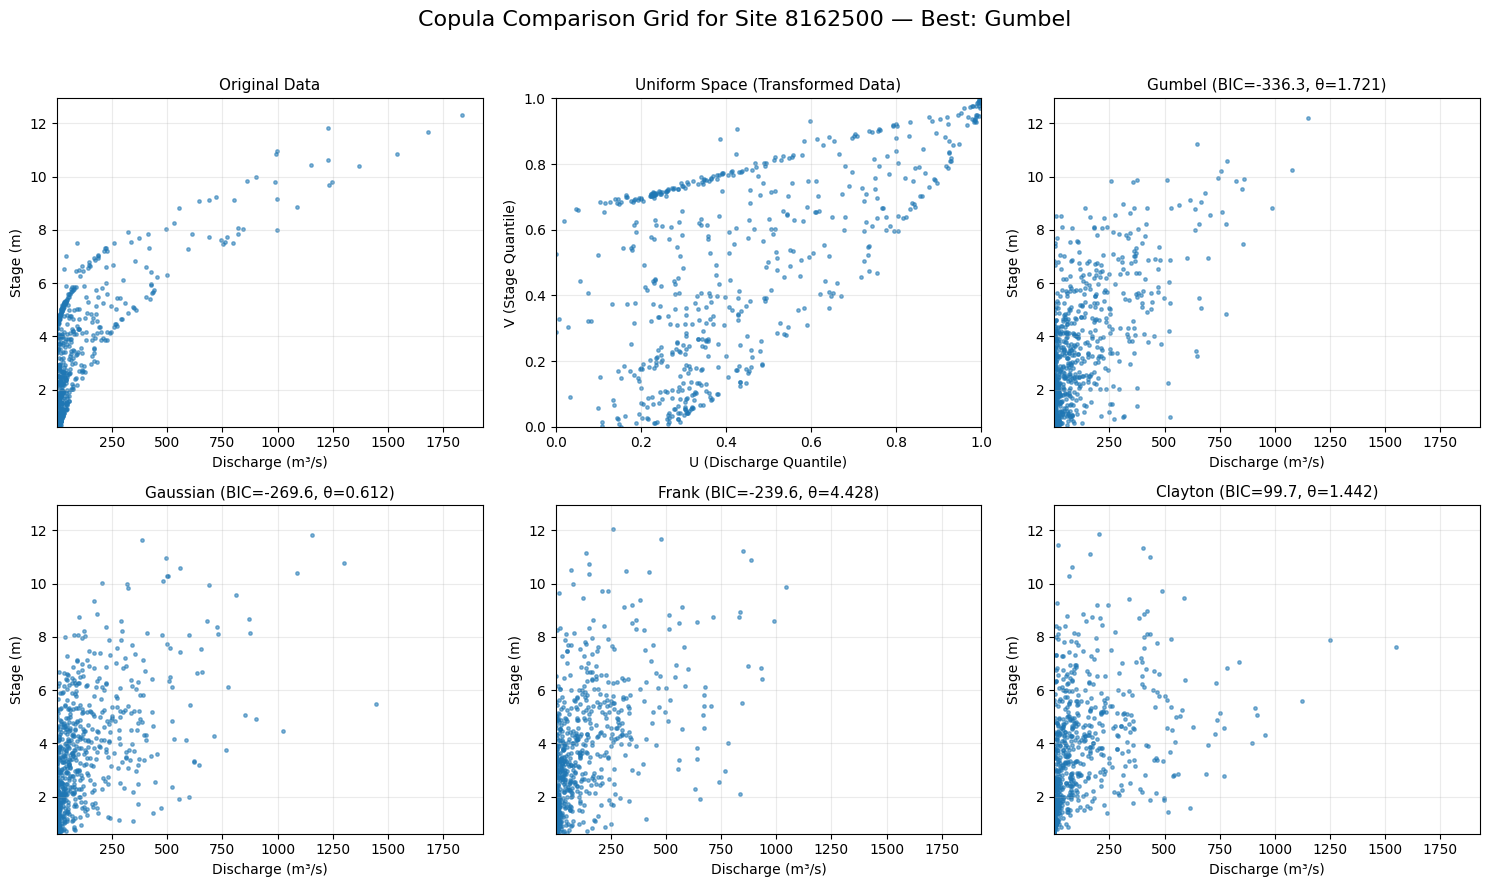

In [9]:
# ==============================================================================
# 5. COPULA ANALYSIS AND SYNTHETIC DATA GENERATION
# ==============================================================================

# --- A. Setup and Configuration for Copula Modeling ---
# This section defines constants and settings used throughout the copula analysis.

# Import necessary libraries (some may be redundant if run in order, but safe to include)
import warnings
from scipy.stats import norm, kendalltau
from copulas.univariate import (
    Univariate, GammaUnivariate, TruncatedGaussian, GaussianUnivariate,
    StudentTUnivariate, BetaUnivariate
)
from copulas.bivariate import Clayton, Frank, Gumbel

# Configuration for reproducibility and numerics
SEED = 42
np.random.seed(SEED)
EPS = 1e-12  # Small constant to avoid log(0) errors

# Configuration for plotting
N_COLS_COPULA_GRID = 3
N_SYNTHETIC_POINTS = 700
POINT_ALPHA = 0.55
POINT_SIZE = 6

# --- B. Custom Gaussian Copula Class (for compatibility and correctness) ---
class GaussianCopulaCompat:
    def __init__(self):
        self.rho = None
    @property
    def theta(self):
        return self.rho
    def fit(self, UV):
        tau = kendalltau(UV[:, 0], UV[:, 1]).correlation
        if tau is None or np.isnan(tau): tau = 0.0
        self.rho = float(np.sin(np.pi * tau / 2))
    def log_probability_density(self, UV):
        Z = norm.ppf(np.clip(UV, EPS, 1-EPS))
        z1, z2 = Z[:, 0], Z[:, 1]
        r = self.rho if self.rho is not None else 0.0
        omr2 = 1.0 - r**2
        return -0.5*np.log(omr2 + EPS) - 0.5*(z1**2 - 2*r*z1*z2 + z2**2)/omr2 + 0.5*(z1**2 + z2**2)
    # This sample method is written to accept either 'n_samples' or 'num_samples'
    def sample(self, n_samples=None, num_samples=None):
        m = n_samples if n_samples is not None else num_samples
        if m is None: raise ValueError("Must provide either 'n_samples' or 'num_samples'.")
        r = self.rho if self.rho is not None else 0.0
        cov = np.array([[1.0, r], [r, 1.0]])
        rng = np.random.default_rng(123)
        Z = rng.multivariate_normal([0.0, 0.0], cov, size=int(m))
        return norm.cdf(Z)

# --- C. Prepare Data for Copula Fitting ---
if 'obs_df_filtered' in locals() and not obs_df_filtered.empty:
    df_clean = obs_df_filtered.rename(columns={'discharge_m3s': 'x', 'stage_m': 'y'})
    print(f"Using the cleaned {len(df_clean)} data points from the rating curve analysis.")
else:
    print("Warning: 'obs_df_filtered' not found. Performing a new cleaning step for copula analysis.")
    df_clean = site_df[['discharge_m3s', 'stage_m']].dropna()
    q_lo, q_hi = df_clean['discharge_m3s'].quantile(0.01), df_clean['discharge_m3s'].quantile(0.99)
    h_lo, h_hi = df_clean['stage_m'].quantile(0.01), df_clean['stage_m'].quantile(0.99)
    df_clean = df_clean[
        (df_clean['discharge_m3s'] > q_lo) & (df_clean['discharge_m3s'] < q_hi) &
        (df_clean['stage_m'] > h_lo) & (df_clean['stage_m'] < h_hi)
    ].copy().rename(columns={'discharge_m3s': 'x', 'stage_m': 'y'})

if len(df_clean) < 20:
    raise ValueError(f"Not enough data points ({len(df_clean)}) for reliable copula fitting.")

# --- D. Fit Marginal Distributions and Transform Data ---
print("\n--- Fitting Marginal Distributions ---")
univariate_candidates = [GammaUnivariate, TruncatedGaussian, GaussianUnivariate, StudentTUnivariate, BetaUnivariate]
ux = Univariate(candidates=univariate_candidates)
ux.fit(df_clean['x'].values)
print(f"Best distribution for Discharge (x): {ux.to_dict()['type'].split('.')[-1]}")
uy = Univariate(candidates=univariate_candidates)
uy.fit(df_clean['y'].values)
print(f"Best distribution for Stage (y): {uy.to_dict()['type'].split('.')[-1]}")
U = np.clip(ux.cdf(df_clean['x'].values), EPS, 1 - EPS)[:, None]
V = np.clip(uy.cdf(df_clean['y'].values), EPS, 1 - EPS)[:, None]
UV = np.hstack([U, V])

# --- E. Fit Copula Models and Select the Best ---
print("\n--- Fitting and Scoring Copula Families ---")
def fit_and_score_copula(name, model, uv):
    model.fit(uv)
    ll = float(model.log_probability_density(uv).sum())
    k, n = 1, len(uv)
    aic = 2*k - 2*ll
    bic = k*np.log(n) - 2*ll
    return {'family': name, 'll': ll, 'AIC': aic, 'BIC': bic}, model

rows_cop, models_cop = [], {}
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    copula_candidates = [
        ('gaussian', GaussianCopulaCompat()), ('clayton',  Clayton()),
        ('frank',    Frank()), ('gumbel',   Gumbel())
    ]
    for name, mdl in copula_candidates:
        try:
            row, fitted_model = fit_and_score_copula(name, mdl, UV)
            rows_cop.append(row)
            models_cop[name] = fitted_model
        except Exception as e:
            print(f"Fit failed for {name}: {e}")

score_cop_df = pd.DataFrame(rows_cop).sort_values('BIC').reset_index(drop=True)
best_name = score_cop_df.loc[0, 'family']
best_model = models_cop[best_name]
print("\nCopula comparison (sorted by BIC):")
print(score_cop_df.to_string(index=False))
print(f"\nBest copula (by BIC): {best_name.title()}")

# --- F. Generate Synthetic Data and Prepare for Plotting ---
print("\n--- Generating Synthetic Data from each Copula ---")
panels_to_plot = [
    ("Original Data", df_clean['x'].values, df_clean['y'].values, 'data'),
    ("Uniform Space (Transformed Data)", UV[:, 0], UV[:, 1], 'uniform')
]
for _, row in score_cop_df.iterrows():
    name = row['family']
    model = models_cop[name]

    ## <-- CORRECTED LINE
    # The library's Bivariate models expect 'n_samples', not 'num_samples'.
    uv_synthetic = model.sample(n_samples=N_SYNTHETIC_POINTS)

    x_synthetic = ux.ppf(uv_synthetic[:, 0])
    y_synthetic = uy.ppf(uv_synthetic[:, 1])
    theta = getattr(model, "theta", None)
    theta_str = f", θ={theta:.3f}" if isinstance(theta, (float, int)) and np.isfinite(theta) else ""
    panel_title = f"{name.title()} (BIC={row['BIC']:.1f}{theta_str})"
    panels_to_plot.append((panel_title, x_synthetic, y_synthetic, 'data'))

# --- G. Create the Final Comparison Grid Plot ---
n_panels = len(panels_to_plot)
n_rows = int(np.ceil(n_panels / N_COLS_COPULA_GRID))
fig, axes = plt.subplots(n_rows, N_COLS_COPULA_GRID, figsize=(N_COLS_COPULA_GRID * 5.0, n_rows * 4.5))
axes = np.atleast_1d(axes).ravel()
x_lims = (df_clean['x'].min(), df_clean['x'].max() * 1.05)
y_lims = (df_clean['y'].min(), df_clean['y'].max() * 1.05)

for ax, (title, x_data, y_data, plot_mode) in zip(axes, panels_to_plot):
    ax.scatter(x_data, y_data, s=POINT_SIZE, alpha=POINT_ALPHA)
    if plot_mode == 'data':
        ax.set_xlim(x_lims)
        ax.set_ylim(y_lims)
        ax.set_xlabel("Discharge (m³/s)")
        ax.set_ylabel("Stage (m)")
    else: # uniform mode
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xlabel("U (Discharge Quantile)")
        ax.set_ylabel("V (Stage Quantile)")
    ax.set_title(title, fontsize=11)
    ax.grid(True, alpha=0.25)

for i in range(n_panels, len(axes)):
    axes[i].axis('off')

fig.suptitle(f"Copula Comparison Grid for Site {TARGET_SITE} — Best: {best_name.title()}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Found fitted rating curve data to include in plots.

Generating a 2x2 grid of prediction plots, sorted by BIC...
--- Generating Prediction Intervals for Gumbel Copula ---


Predicting with Gumbel:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/copulas/bivariate/gumbel.py:52: RuntimeWarning: divide by zero encountered in power
  a = np.power(U * V, -1)
/usr/local/lib/python3.12/dist-packages/copulas/bivariate/gumbel.py:53: RuntimeWarning: divide by zero encountered in log
  tmp = np.power(-np.log(U), self.theta) + np.power(-np.log(V), self.theta)
/usr/local/lib/python3.12/dist-packages/copulas/bivariate/gumbel.py:55: RuntimeWarning: divide by zero encountered in log
  c = np.power(np.log(U) * np.log(V), self.theta - 1)
/usr/local/lib/python3.12/dist-packages/copulas/bivariate/gumbel.py:82: RuntimeWarning: divide by zero encountered in log
  h = np.power(-np.log(U), self.theta) + np.power(-np.log(V), self.theta)
/usr/local/lib/python3.12/dist-packages/copulas/bivariate/gumbel.py:57: RuntimeWarning: invalid value encountered in multiply
  return self.cumulative_distribution(X) * a * b * c * d
/tmp/ipython-input-1507944485.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` i

--- Generating Prediction Intervals for Gaussian Copula ---


Predicting with Gaussian:   0%|          | 0/100 [00:00<?, ?it/s]

--- Generating Prediction Intervals for Frank Copula ---


Predicting with Frank:   0%|          | 0/100 [00:00<?, ?it/s]

--- Generating Prediction Intervals for Clayton Copula ---


Predicting with Clayton:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/copulas/bivariate/clayton.py:56: RuntimeWarning: divide by zero encountered in power
  a = (self.theta + 1) * np.power(U * V, -(self.theta + 1))
/usr/local/lib/python3.12/dist-packages/copulas/bivariate/clayton.py:57: RuntimeWarning: divide by zero encountered in power
  b = np.power(U, -self.theta) + np.power(V, -self.theta) - 1
/usr/local/lib/python3.12/dist-packages/copulas/bivariate/clayton.py:59: RuntimeWarning: invalid value encountered in multiply
  return a * np.power(b, c)


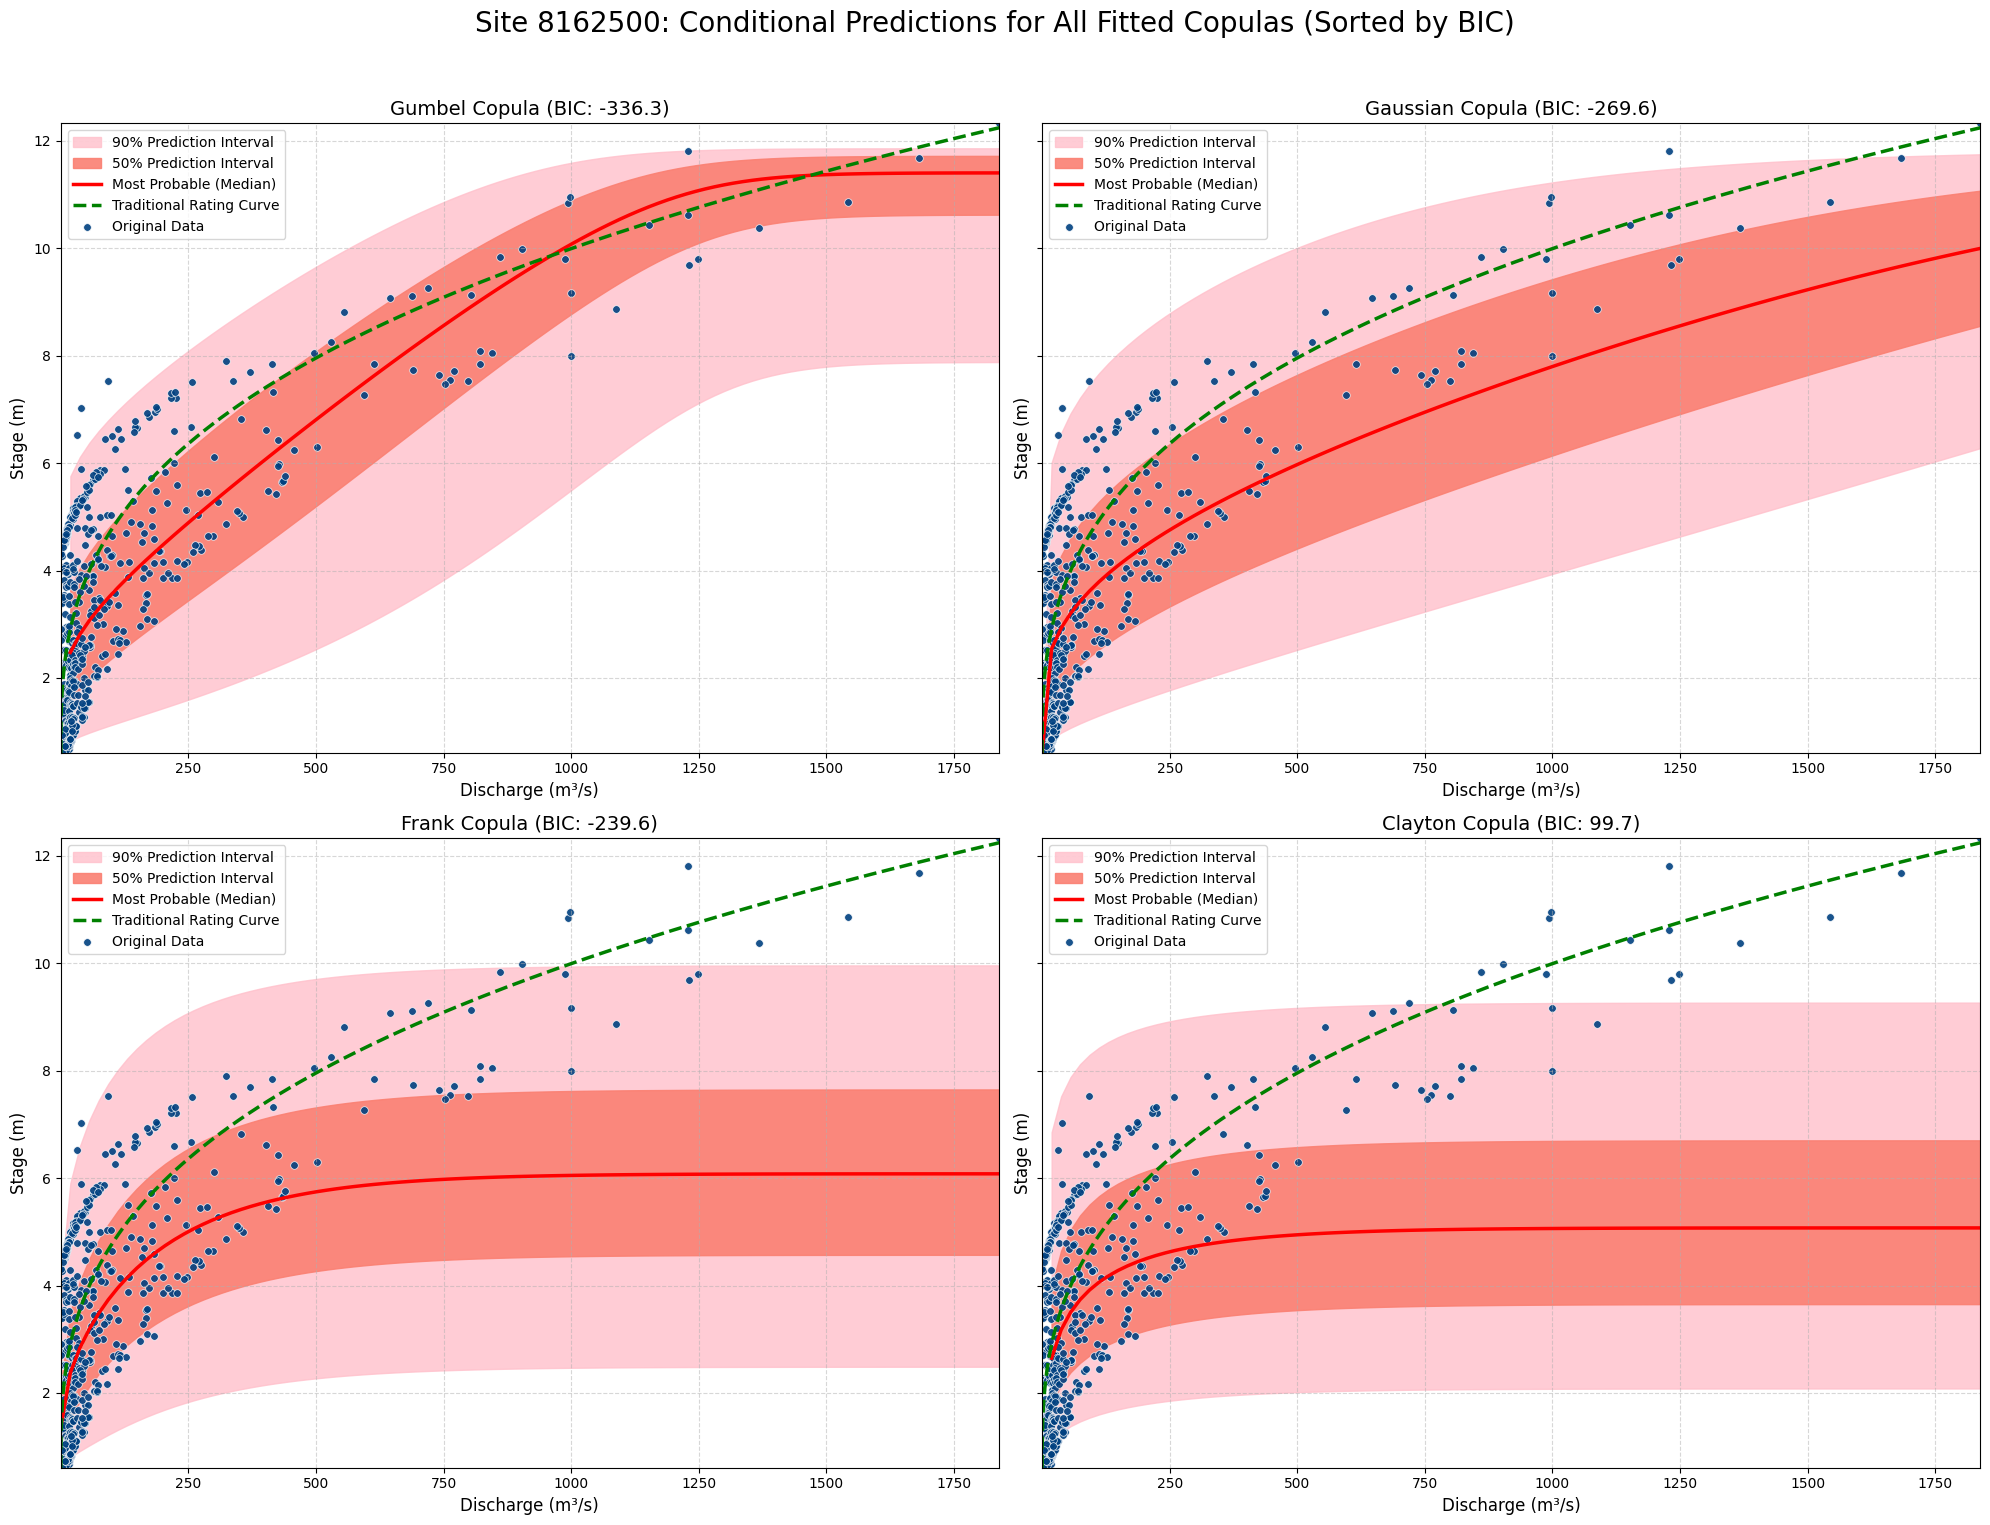

In [10]:
# ==============================================================================
# 6. CONDITIONAL PREDICTION PLOTS FOR ALL FITTED COPULAS
# ==============================================================================
# This cell generates the final, MATLAB-style prediction plots for every copula
# family that was successfully fitted. The plots are ordered by their BIC score.

# --- A. Setup and Dependency Check ---
from tqdm.notebook import tqdm # Use the notebook-friendly version of tqdm

# This block safely checks if the rating curve data from the previous cell exists.
try:
    rating_curve_q = Q_fit_rc
    rating_curve_h = H_grid_rc
    print("Found fitted rating curve data to include in plots.")
except NameError:
    print("\nWARNING: Rating curve variables (Q_fit_rc, H_grid_rc) not found.")
    print("The rating curve will NOT be included in the plots.")
    rating_curve_q = None
    rating_curve_h = None

# --- B. Helper Functions for Prediction and Plotting ---
def predict_conditional_stage(specific_discharge, ux, uy, copula_model, n_points=1000):
    """Calculates the conditional probability distribution of Stage given a specific Discharge."""
    s_min, s_max = uy.ppf(0.001), uy.ppf(0.999)
    stage_grid = np.linspace(s_min, s_max, n_points)
    u1_cond = ux.cdf(np.array([specific_discharge]))
    u2_grid = uy.cdf(stage_grid)
    marginal_density_stage = uy.pdf(stage_grid)
    u_input = np.column_stack([np.repeat(u1_cond, n_points), u2_grid])
    log_copula_density = copula_model.log_probability_density(u_input)
    copula_density = np.exp(log_copula_density)
    conditional_density = copula_density * marginal_density_stage
    total_area = np.trapz(conditional_density, stage_grid)
    if total_area > 1e-8:
        conditional_density /= total_area
    return stage_grid, conditional_density

def get_quantiles_from_density(stage_grid, density, quantiles_to_find):
    """Calculates specific quantiles from a probability density function."""
    cdf = np.cumsum(density) * (stage_grid[1] - stage_grid[0])
    cdf /= cdf[-1]
    return np.interp(quantiles_to_find, cdf, stage_grid)

def create_prediction_plot(ax, model, model_name, discharge_data, stage_data, q_rc, h_rc):
    """Generates the full conditional prediction plot on a given matplotlib axis."""
    print(f"--- Generating Prediction Intervals for {model_name} Copula ---")

    discharge_grid = np.linspace(discharge_data.min(), discharge_data.max(), 100)
    quantiles_to_find = [0.05, 0.25, 0.50, 0.75, 0.95]
    predicted_quantiles = []

    for q_value in tqdm(discharge_grid, desc=f'Predicting with {model_name}', leave=False):
        stage_grid, density = predict_conditional_stage(q_value, ux, uy, model)
        if np.sum(density) > 1e-8:
            predicted_quantiles.append(get_quantiles_from_density(stage_grid, density, quantiles_to_find))
        else:
            predicted_quantiles.append([np.nan] * len(quantiles_to_find))

    predicted_quantiles = np.array(predicted_quantiles)

    # Plotting Layers
    ax.fill_between(discharge_grid, predicted_quantiles[:, 0], predicted_quantiles[:, 4], color='pink', alpha=0.8, label='90% Prediction Interval')
    ax.fill_between(discharge_grid, predicted_quantiles[:, 1], predicted_quantiles[:, 3], color='salmon', alpha=0.9, label='50% Prediction Interval')
    ax.plot(discharge_grid, predicted_quantiles[:, 2], 'r-', lw=2.5, label='Most Probable (Median)')
    if q_rc is not None and h_rc is not None:
        ax.plot(q_rc, h_rc, 'g--', lw=2.5, label='Traditional Rating Curve')
    ax.scatter(discharge_data, stage_data, s=30, alpha=0.9, color="#004080", label="Original Data", edgecolors='w', linewidth=0.5)

    # Formatting
    ax.set_xlabel("Discharge (m³/s)", fontsize=12)
    ax.set_ylabel("Stage (m)", fontsize=12)
    ax.set_title(f"{model_name} Copula", fontsize=14)
    ax.legend(loc="upper left")
    ax.grid(True, alpha=0.5, linestyle='--')
    ax.set_xlim(discharge_data.min(), discharge_data.max())
    ax.set_ylim(stage_data.min(), stage_data.max())

# --- C. Create the Comparison Plot Grid ---
# Determine grid size based on the number of successfully fitted copulas
num_models = len(score_cop_df)
n_cols_grid = 2
n_rows_grid = int(np.ceil(num_models / n_cols_grid))

fig, axes = plt.subplots(n_rows_grid, n_cols_grid, figsize=(10 * n_cols_grid, 8 * n_rows_grid), sharey=True)
axes_flat = axes.flatten()

print(f"\nGenerating a {n_rows_grid}x{n_cols_grid} grid of prediction plots, sorted by BIC...")

# --- D. Loop through the Sorted Copulas and Create Each Plot ---
for i, (_, row) in enumerate(score_cop_df.iterrows()):
    ax = axes_flat[i]
    model_name = row['family']
    bic_score = row['BIC']
    copula_model = models_cop[model_name]

    create_prediction_plot(ax, copula_model, model_name.title(), df_clean['x'], df_clean['y'], rating_curve_q, rating_curve_h)

    ax.set_title(f"{model_name.title()} Copula (BIC: {bic_score:.1f})", fontsize=14)

# Hide any unused subplots
for i in range(num_models, len(axes_flat)):
    axes_flat[i].set_visible(False)

# --- E. Final Figure Formatting ---
fig.suptitle(f"Site {TARGET_SITE}: Conditional Predictions for All Fitted Copulas (Sorted by BIC)", fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

**Conditional Distribution Estimation via Copula Theory**

The primary predictive task of this analysis is to estimate the conditional probability distribution of river stage (r₂) given a specific value of river discharge (r₁). This is formally denoted as f(r₂ | r₁).

**Theoretical Foundation: The Conditional Density Formula**

The derivation is grounded in copula theory, specifically leveraging the relationship between the joint, marginal, and copula density functions. The governing equation for the conditional probability density function (PDF) is:

f(r₂ | r₁) = c(u₁, u₂) ⋅ f₂(r₂)

where:

    f(r₂ | r₁) is the conditional PDF of r₂ given r₁. This is the desired predictive distribution.

    c(u₁, u₂) is the copula probability density function. It quantifies the dependence structure between the two variables, independent of their marginal behaviors. The variables u₁ and u₂ are the uniform transformations of r₁ and r₂ obtained via their respective marginal CDFs (u = F(r)).

    f₂(r₂) is the marginal PDF of the variable r₂ (Stage). It describes the underlying probability distribution of Stage irrespective of Discharge.

**Implementation in the Python Code**

Our Python function, predict_conditional_stage, provides a direct numerical implementation of this formula. The function decomposes the problem as follows:

    Marginal Density f₂(r₂): This term is computed by evaluating the pdf method of the fitted Univariate object for the Stage variable (uy). The input is a grid of r₂ values, and the output is their corresponding marginal probability densities.

    Copula Density c(u₁, u₂): This term is calculated by evaluating the log_probability_density method of the fitted bivariate copula model (e.g., best_model). The result is then exponentiated (np.exp) to convert the log-density into the required probability density.

    Conditional Density f(r₂ | r₁): The final predictive distribution is obtained by performing an element-wise multiplication of the two components calculated above.

All necessary models and functions are loaded and ready.

--- Generating prediction for a discharge of 500.00 m³/s ---

--- Prediction Results ---
The single most likely value (median) for the stage is: 6.81 m
The 50% Prediction Interval (likely range) is: [5.20, 8.08] m
The 90% Prediction Interval (very likely range) is: [2.54, 9.65] m


/tmp/ipython-input-1507944485.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_area = np.trapz(conditional_density, stage_grid)


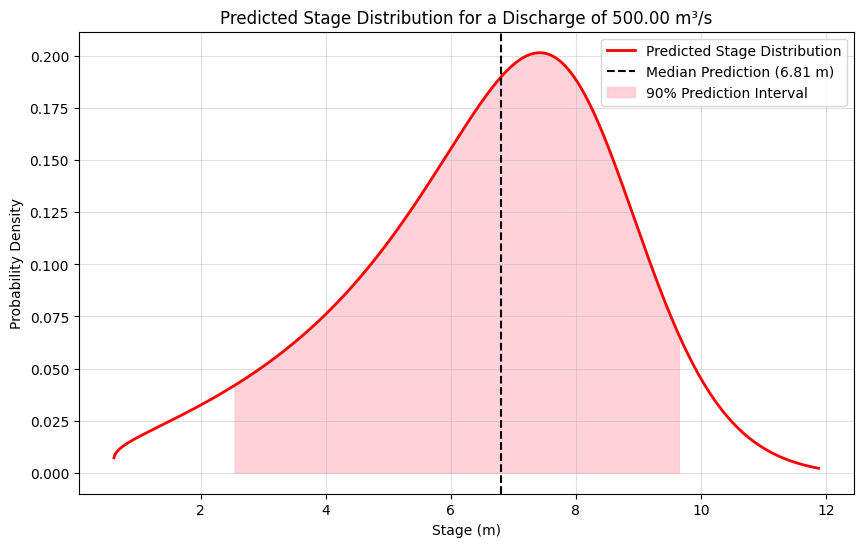

In [11]:
# ==============================================================================
# 7. INTERACTIVE CONDITIONAL PREDICTION
# ==============================================================================
# This cell uses the best-fit copula model and the helper functions defined
# previously to make a prediction for a single, user-defined discharge value.

# --- A. Setup and Dependency Check ---
# Ensure the helper functions and fitted models from the previous cells are available.
try:
    # Check for the existence of the main objects we need
    _ = best_model
    _ = ux
    _ = uy
    _ = predict_conditional_stage
    _ = get_quantiles_from_density
    print("All necessary models and functions are loaded and ready.")
except NameError:
    print("ERROR: It appears the previous cells have not been run successfully.")
    print("Please run the cells for 'Copula Analysis' and 'Prediction Plots' before this one.")
    exit()

# --- B. User Input: Define the Discharge Value ---
# ==================================================
# EDIT THIS VALUE to make a new prediction.
specific_discharge_value = 500
# To use a percentile instead, uncomment the line below and comment out the line above
# specific_discharge_value = df_clean['x'].quantile(0.90)
# ==================================================

print(f"\n--- Generating prediction for a discharge of {specific_discharge_value:.2f} m³/s ---")

# --- C. Generate the Predicted Distribution ---
# Use our helper function to get the full probability density curve for the stage.
stage_grid, predicted_density = predict_conditional_stage(
    specific_discharge_value,
    ux,
    uy,
    best_model  # Using the best-fit copula identified earlier
)

# --- D. Derive and Display Key Stage Values (The Prediction) ---
# Check if the prediction was successful before trying to extract values
if np.sum(predicted_density) > 1e-8:
    # Define the quantiles (percentiles) we want to extract from the distribution
    quantiles_to_find = [0.05, 0.25, 0.50, 0.75, 0.95]

    # Use our helper function to get the stage values for these quantiles
    stage_values = get_quantiles_from_density(stage_grid, predicted_density, quantiles_to_find)

    # Unpack the results into clearly named variables
    p05_stage = stage_values[0]
    p25_stage = stage_values[1]
    median_stage = stage_values[2]
    p75_stage = stage_values[3]
    p95_stage = stage_values[4]

    print("\n--- Prediction Results ---")
    print(f"The single most likely value (median) for the stage is: {median_stage:.2f} m")
    print(f"The 50% Prediction Interval (likely range) is: [{p25_stage:.2f}, {p75_stage:.2f}] m")
    print(f"The 90% Prediction Interval (very likely range) is: [{p05_stage:.2f}, {p95_stage:.2f}] m")

    # --- E. Visualize the Predicted Distribution ---
    plt.figure(figsize=(10, 6))
    plt.plot(stage_grid, predicted_density, 'r-', lw=2, label='Predicted Stage Distribution')

    # Add visual markers for the key values
    plt.axvline(median_stage, color='black', linestyle='--', label=f'Median Prediction ({median_stage:.2f} m)')
    plt.fill_between(stage_grid, predicted_density, where=((stage_grid >= p05_stage) & (stage_grid <= p95_stage)),
                     color='pink', alpha=0.7, label=f'90% Prediction Interval')

    # Formatting
    plt.xlabel("Stage (m)")
    plt.ylabel("Probability Density")
    plt.title(f"Predicted Stage Distribution for a Discharge of {specific_discharge_value:.2f} m³/s")
    plt.legend()
    plt.grid(True, alpha=0.4)
    plt.show()

else:
    print("\nERROR: Could not generate a valid prediction for the given discharge value.")